##Displaying January and July temperature data for Montana, United States

Authors : Lyra Reynolds

## The data
There are two datasets from the Montana Climate Office.  

`MT_monthly_temp.csv` has the monthly mean for all pf the stations across the state by month.

`MT_station_meta.csv` provides more information on each station, as well as the lat and lon of each station.

## Calculations and displays in this Notebook

1. The skew, kurtosis, mean, and median, standard deviation of the mean min and max temperatures by station.
2. The skew, kurtosis, mean, and median, standard deviation of the mean min and max temperatures by year.
3. Two histograms of min and mean temperatures.
4. For all of the data calculate the statistical probability that the min temperature will be below zero (C). Show the histograms that represent this visually. See figures 6.3 and 6.4 for examples.
5. For all of the data calculate the statistical probability that the max temperature will be below zero (C). Show the histograms that represent this visually. See figures 6.3 and 6.4 for examples.
6. Two maps in the same frame (2 subplots). 
- One should have January mean temperature for  for each station.
- The second map should have A map with of July mean monthly temperature for July for each station.
- Temperatures should be represented by an intuitive color scheme.
- The map should have an outline of Montana.
- Bonus points if you have a backgound map.
7. The geographic center of these weather stations should also be represented and labeled on the maps.


*This notebook was part of a midterm assessment for GPHY 484 course at Montana State University. Though this project was assigned, all code was written by the notebook's authors*



# Import Libraries & files

In [1]:
#install, import, and load libraries
import pandas as pd #import will import & load the library
!pip install geopandas -q  #q will remove the noise from the install
import geopandas as gpd
import seaborn as sns
!pip install contextily -q #install will install the library for import
import contextily as ctx
import xyzservices.providers as xyz
import matplotlib as mpl
import matplotlib.pyplot as plt
!pip install git+https://github.com/pysal/libpysal.git -q
import libpysal as ps
!pip install git+https://github.com/pysal/pointpats.git -q
import pointpats
from pointpats import distance_statistics
from pointpats import PointPattern, PoissonPointProcess, as_window
import numpy as np
import scipy.spatial
!pip install folium -q
import folium
from scipy.stats import norm
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import variation
from shapely.geometry import Point
import math


     |████████████████████████████████| 1.0 MB 15.5 MB/s 
     |████████████████████████████████| 16.7 MB 11.3 MB/s 
     |████████████████████████████████| 6.3 MB 7.9 MB/s 
     |████████████████████████████████| 19.3 MB 8.9 MB/s 
     |████████████████████████████████| 66.7 MB 22 kB/s 


In [2]:
# upload CSVs
from google.colab import files
uploaded = files.upload()


Saving MT_monthly_temp.csv to MT_monthly_temp.csv
Saving MT_station_meta.csv to MT_station_meta.csv


# Creating, cleaning, and grouping dataframes

In [3]:
TempData = pd.read_csv("MT_monthly_temp.csv") #reading the CSV and printing the dataframe
TempData

,station_key,month,year,mean_min_temp,mean_max_temp
0,arskeogh,6,2017,16.250000,28.634000
1,arskeogh,7,2017,19.311290,35.413226
2,arskeogh,8,2017,14.697097,30.743548
3,arskeogh,9,2017,9.730667,23.623333
4,arskeogh,10,2017,2.243871,17.240645
...,...,...,...,...,...
3394,wsrreeds,11,2021,0.270667,11.379333
3395,wsrreeds,12,2021,-8.030645,1.766452
3396,wsrreeds,1,2022,-6.501290,3.712581
3397,wsrreeds,2,2022,-8.829643,2.922500


In [4]:
StationData = pd.read_csv("MT_station_meta.csv") #read CSV and print data frame
StationData

,station,name,date_installed,sub_network,longitude,latitude,elevation,mesowest_id,gwic_id
0,arskeogh,Fort Keogh N,2017-06-26,AgriMet,-105.95,46.41,818.85,MTM23,NaN
1,arskeose,Fort Keogh SE,2018-06-19,AgriMet,-105.83,46.35,746.04,MTM25,NaN
2,arskeosw,Fort Keogh SW,2018-06-26,AgriMet,-105.98,46.30,849.20,MTM26,NaN
3,bentlake,Benton Lake W,2017-07-01,AgriMet,-111.47,47.69,1129.44,MTM21,NaN
4,blm1arge,Argenta,2017-08-18,AgriMet,-112.88,45.25,1898.93,MTM14,NaN
...,...,...,...,...,...,...,...,...,...
77,wsrbigtm,Big Timber SE,2019-07-02,AgriMet,-109.83,45.74,1335.29,MTM63,NaN
78,wsrboydw,Cooney Reservoir W,2018-09-21,AgriMet,-109.26,45.47,1429.65,MTM64,NaN
79,wsrbroad,Broadview E,2018-09-30,AgriMet,-108.76,46.13,1239.41,MTM65,NaN
80,wsrmelvi,Melville SE,2019-07-03,AgriMet,-109.84,46.00,1430.15,MTM66,NaN


In [5]:
#merge two CSV into one data set, print the merged data frame
merged = pd.merge(TempData, StationData,
                  left_on='station_key', right_on='station')
print(merged)

     station_key  month  year  mean_min_temp  mean_max_temp   station  \
0       arskeogh      6  2017      16.250000      28.634000  arskeogh   
1       arskeogh      7  2017      19.311290      35.413226  arskeogh   
2       arskeogh      8  2017      14.697097      30.743548  arskeogh   
3       arskeogh      9  2017       9.730667      23.623333  arskeogh   
4       arskeogh     10  2017       2.243871      17.240645  arskeogh   
...          ...    ...   ...            ...            ...       ...   
3394    wsrreeds     11  2021       0.270667      11.379333  wsrreeds   
3395    wsrreeds     12  2021      -8.030645       1.766452  wsrreeds   
3396    wsrreeds      1  2022      -6.501290       3.712581  wsrreeds   
3397    wsrreeds      2  2022      -8.829643       2.922500  wsrreeds   
3398    wsrreeds      3  2022       5.900000      12.210000  wsrreeds   

              name date_installed sub_network  longitude  latitude  elevation  \
0     Fort Keogh N     2017-06-26     Agri

In [6]:
clean = merged.drop(columns = [ 'date_installed', 'sub_network', 'mesowest_id','gwic_id']) 
#drop individual columns from the merge data frame, makes it look cleaner & name the cleaned up data frame "clean"
clean

,station_key,month,year,mean_min_temp,mean_max_temp,station,name,longitude,latitude,elevation
0,arskeogh,6,2017,16.250000,28.634000,arskeogh,Fort Keogh N,-105.95,46.41,818.85
1,arskeogh,7,2017,19.311290,35.413226,arskeogh,Fort Keogh N,-105.95,46.41,818.85
2,arskeogh,8,2017,14.697097,30.743548,arskeogh,Fort Keogh N,-105.95,46.41,818.85
3,arskeogh,9,2017,9.730667,23.623333,arskeogh,Fort Keogh N,-105.95,46.41,818.85
4,arskeogh,10,2017,2.243871,17.240645,arskeogh,Fort Keogh N,-105.95,46.41,818.85
...,...,...,...,...,...,...,...,...,...,...
3394,wsrreeds,11,2021,0.270667,11.379333,wsrreeds,Reed Point S,-109.56,45.61,1429.43
3395,wsrreeds,12,2021,-8.030645,1.766452,wsrreeds,Reed Point S,-109.56,45.61,1429.43
3396,wsrreeds,1,2022,-6.501290,3.712581,wsrreeds,Reed Point S,-109.56,45.61,1429.43
3397,wsrreeds,2,2022,-8.829643,2.922500,wsrreeds,Reed Point S,-109.56,45.61,1429.43


In [7]:
#Group data from cleaned data by Year, year is placed as a column rather than index
Year = clean.groupby(['year'],as_index=False).mean()
print(Year)

#turn the group by series into a dataframe that statistics can be calculated on (thank you Stack Overflow!)
ByYear = pd.DataFrame(Year)
ByYear

   year      month  mean_min_temp  mean_max_temp   longitude   latitude  \
0  2016  10.809524      -0.247947       8.765768 -111.726667  47.520476   
1  2017   7.882682       1.942207      14.876932 -110.467039  46.867933   
2  2018   7.746341       0.906725      12.760256 -109.792756  46.633293   
3  2019   6.927614      -0.163830      11.774615 -109.459678  46.706367   
4  2020   6.499438       0.992208      14.480792 -109.406175  46.784736   
5  2021   6.656555       1.400982      15.357373 -109.405601  46.716815   
6  2022   1.982684      -5.643316       4.829778 -109.445325  46.635628   

     elevation  
0  1007.461905  
1  1144.185084  
2  1163.734341  
3  1140.439437  
4  1118.051462  
5  1128.322795  
6  1152.943160  


,year,month,mean_min_temp,mean_max_temp,longitude,latitude,elevation
0,2016,10.809524,-0.247947,8.765768,-111.726667,47.520476,1007.461905
1,2017,7.882682,1.942207,14.876932,-110.467039,46.867933,1144.185084
2,2018,7.746341,0.906725,12.760256,-109.792756,46.633293,1163.734341
3,2019,6.927614,-0.163830,11.774615,-109.459678,46.706367,1140.439437
4,2020,6.499438,0.992208,14.480792,-109.406175,46.784736,1118.051462
5,2021,6.656555,1.400982,15.357373,-109.405601,46.716815,1128.322795
6,2022,1.982684,-5.643316,4.829778,-109.445325,46.635628,1152.943160


In [8]:
#Group data from cleaned data frame by station ID, Station is placed as a column rather than an index
Station = clean.groupby(['station_key'],as_index=False).mean()
print(Station)

#turn the group by series into a dataframe that statistics can be calculated on (thank you Stack Overflow!)
ByStation = pd.DataFrame(Station)
ByStation


   station_key     month         year  mean_min_temp  mean_max_temp  \
0     arskeogh  6.568966  2019.327586       2.127577      14.906129   
1     arskeose  6.772727  2019.727273       0.878413      15.872328   
2     arskeosw  6.586957  2019.826087       3.078341      15.290302   
3     bentlake  6.578947  2019.368421      -0.483262      13.645283   
4     blm1arge  6.571429  2019.410714      -0.201337      11.301887   
..         ...       ...          ...            ...            ...   
77    wsrbigtm  6.636364  2020.363636       2.915667      15.015599   
78    wsrboydw  6.558140  2019.953488       1.100326      12.115038   
79    wsrbroad  6.558140  2019.953488       1.142196      12.900847   
80    wsrmelvi  6.636364  2020.363636       1.174400      14.257587   
81    wsrreeds  6.558140  2019.953488       1.079450      12.680275   

    longitude  latitude  elevation  
0     -105.95     46.41     818.85  
1     -105.83     46.35     746.04  
2     -105.98     46.30     849.20  

,station_key,month,year,mean_min_temp,mean_max_temp,longitude,latitude,elevation
0,arskeogh,6.568966,2019.327586,2.127577,14.906129,-105.95,46.41,818.85
1,arskeose,6.772727,2019.727273,0.878413,15.872328,-105.83,46.35,746.04
2,arskeosw,6.586957,2019.826087,3.078341,15.290302,-105.98,46.30,849.20
3,bentlake,6.578947,2019.368421,-0.483262,13.645283,-111.47,47.69,1129.44
4,blm1arge,6.571429,2019.410714,-0.201337,11.301887,-112.88,45.25,1898.93
...,...,...,...,...,...,...,...,...
77,wsrbigtm,6.636364,2020.363636,2.915667,15.015599,-109.83,45.74,1335.29
78,wsrboydw,6.558140,2019.953488,1.100326,12.115038,-109.26,45.47,1429.65
79,wsrbroad,6.558140,2019.953488,1.142196,12.900847,-108.76,46.13,1239.41
80,wsrmelvi,6.636364,2020.363636,1.174400,14.257587,-109.84,46.00,1430.15


# Calculating statistics & visualize data

In [9]:
#find statistics for grouping by Station for min temp (MinS indicates minimum temp by station)
MinSmean = ByStation['mean_min_temp'].mean()
MinSkurtosis = scipy.stats.kurtosis(ByStation["mean_min_temp"])
MinSmedian = np.median(ByStation["mean_min_temp"])
MinSdev = np.std(ByStation['mean_min_temp'])
MinSskew = ByStation['mean_min_temp'].skew()

#place all statistics for the min temp by stations in one data frame (MinS)
data = {'Statistic':['skew', 'kurtosis', 'mean', 'median', 'standard deviation'],
        'Value': [MinSskew, MinSkurtosis, MinSmean, MinSmedian, MinSdev]}
MinS=pd.DataFrame(data)
print(MinS)

            Statistic     Value
0                skew  0.018056
1            kurtosis  1.362618
2                mean  0.325705
3              median  0.472482
4  standard deviation  1.784057


In [10]:
#find statistics for grouping by Station for max temp (MaxS indicates maximum temp by station)
MaxSmean = ByStation['mean_max_temp'].mean()
MaxSkurtosis = scipy.stats.kurtosis(ByStation["mean_max_temp"])
MaxSmedian = np.median(ByStation["mean_max_temp"])
MaxSdev = np.std(ByStation['mean_max_temp'])
MaxSskew = ByStation['mean_max_temp'].skew()

#place all statistics for the max temp by stations in one data frame (MaxS)
data = {'Statistic':['skew', 'kurtosis', 'mean', 'median', 'standard deviation'],
        'Value': [MaxSskew, MaxSkurtosis, MaxSmean, MaxSmedian, MaxSdev]}
MaxS=pd.DataFrame(data)
print(MaxS)

            Statistic      Value
0                skew  -0.829416
1            kurtosis   0.827957
2                mean  13.174044
3              median  13.310016
4  standard deviation   2.030115


In [11]:
#find statistics for grouping by Year for min temp (MinY indicates minimum temp by year)
MinYmean = ByYear['mean_min_temp'].mean()
MinYkurtosis = scipy.stats.kurtosis(ByYear["mean_min_temp"])
MinYmedian = np.median(ByYear["mean_min_temp"])
MinYdev = np.std(ByYear['mean_min_temp'])
MinYskew = ByYear['mean_min_temp'].skew()

#place all statistics for the min temp by year in one data frame (MinY)
data = {'Statistic':['skew', 'kurtosis', 'mean', 'median', 'standard deviation'],
        'Value': [MinYskew, MinYkurtosis, MinYmean, MinYmedian, MinYdev]}
MinY=pd.DataFrame(data)
print(MinY)

            Statistic     Value
0                skew -2.139766
1            kurtosis  1.328847
2                mean -0.116139
3              median  0.906725
4  standard deviation  2.371933


In [12]:
#find statistics for grouping by Year for max temp (MaxY indicates maximum temp by year)
MaxYmean = ByYear['mean_max_temp'].mean()
MaxYkurtosis = scipy.stats.kurtosis(ByYear["mean_max_temp"])
MaxYmedian = np.median(ByYear["mean_max_temp"])
MaxYdev = np.std(ByYear['mean_max_temp'])
MaxYskew = ByYear['mean_max_temp'].skew()

#place all statistics for the Max temp by year in one data frame (MaxY)
data = {'Statistic':['skew', 'kurtosis', 'mean', 'median', 'standard deviation'],
        'Value': [MaxYskew, MaxYkurtosis, MaxYmean, MaxYmedian, MaxYdev]}
MaxY=pd.DataFrame(data)
print(MaxY)

            Statistic      Value
0                skew  -1.169265
1            kurtosis  -0.482185
2                mean  11.835074
3              median  12.760256
4  standard deviation   3.545898


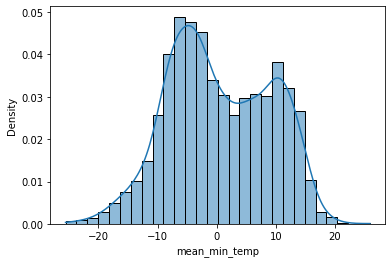

In [13]:
#Histogram of the Mean Minimum Temperature 
import matplotlib.pyplot as plt
sns.histplot(data = clean, x = clean["mean_min_temp"], kde = True, stat='density', common_norm=True ) #normalizes data
#density stat normalizes the values so the area in the histogram is 1 - allows
#for normal distribution statistics to be 


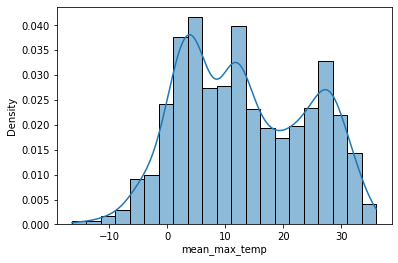

In [14]:
#Histogram with seaborn with mean plotted as the red line
import matplotlib.pyplot as plt
sns.histplot(data = clean, x = clean["mean_max_temp"], kde = True, stat='density',common_norm=True ) #normalizes data )
#density stat normalizes the values so the area in the histogram is 1 - allows
#for normal distribution statistics to be applies

# Statistical likelihoods using z-scores

the zscore for min temp when temp is zero is -0.05001060495525695


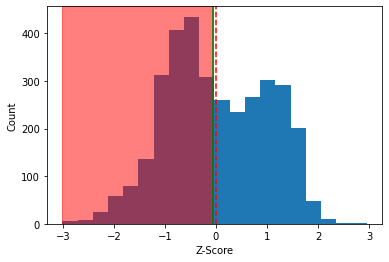

In [15]:
#data is normally distributed, as it appears centered around the mean, has an 
#area under the histogram of 1, and 99% of values are within 3 standard
#deviations of the mean, so we can conduct a standard score test
#setting variable values for the standard score equation to find probability of min temp below zero
xbar = clean['mean_min_temp'].mean() #mean
obs = 0 #observation of 0 degrees
sd = np.std(clean['mean_min_temp']) #std deviation

##Finding the Z-score associated with a minimum temperature of 0, uses equation 6.1 from TextBook
zscoremin = (obs-xbar)/sd #z-score at temp of 0 degrees C
print("the zscore for min temp when temp is zero is", zscoremin)

#set up variable for plotting the zscores of all values to show histogram for probabilities
vals = clean['mean_min_temp'] #assigning all minimum temp data to variable 'vals' 
zscores = (vals - xbar)/sd #calculating the z-scores for all minimum temps
zscoremean = (xbar-xbar)/sd #variable for the z-score of the mean (should be 0)
minzscore = zscores.min() #lowest zscore for the edge of the histogram shading of probability

#plot the Z-scores histogram
f, ax = plt.subplots(1)
plt.hist(zscores, bins = 20)
ax.set_xlabel('Z-Score') #x-axis title
ax.set_ylabel('Count') #y-axis title
plt.axvline(zscoremean, color='r', linestyle='--', label = "Mean") #plot the mean zscore (0)
plt.axvline(zscoremin, color = 'g', linestyle= '-', label = '0 Degrees Celcius') #plot 0 degrees C zscore
ax.axvspan(minzscore, zscoremin, alpha=0.5, color='red') #shows the shaded area of the below 0 temps
plt.show()

The z-score of -0.05 corresponds to the probability level of 0.0199 according to the Z-score table here: https://www.mathsisfun.com/data/standard-normal-distribution-table.html
This means that about 2% of the values under the normal curve that are between zero degrees and the mean of the mean minimum temperature from the data sets. When looking for the probability of the temperature below zero, I subtrated 0.0199 from 0.5, as 0.5 is the portion of the curve that lies below the mean. **Therefore, the probability that the mean minimum temperature will be below zero is about 48%.**

the zscore for max temp when temp is zero is -1.2172220193822414
13.249320599598066


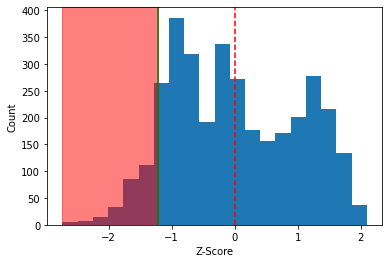

In [16]:
#setting variable values for the standard score equation to find probability of max temp below zero
xbarM = clean['mean_max_temp'].mean() #mean
obs = 0 #observation of 0 degress celcius
sdM = np.std(clean['mean_max_temp']) #std deviation

##Finding the Z-score associated with a maximum temperature of 0, uses equation 6.1 from TextBook
zscoreMax = (obs-xbarM)/sdM
print("the zscore for max temp when temp is zero is", zscoreMax)
print(xbarM)

valsMax = clean['mean_max_temp'] #assigning all maximum temp data to variable 'valsMax' 
zscoresMax = (valsMax - xbarM)/sdM #calculating the z-scores for all maximum temps
zscoremeanMax = (xbarM-xbarM)/sdM #variable for the z-score of the mean (should be 0)
minzscoreM = zscoresMax.min() #lowest zscore for the edge of the histogram shading of probability

#plot the Z-scores histogram
f, ax = plt.subplots(1)
plt.hist(zscoresMax, bins = 20)
ax.set_xlabel('Z-Score') #x-axis title
ax.set_ylabel('Count') #y-axis title
plt.axvline(zscoremeanMax, color='r', linestyle='--', label = "Mean") #plot the mean
plt.axvline(zscoreMax, color = 'g', linestyle= '-', label = '0 Degrees Celcius') #plot 0 degrees C
ax.axvspan(minzscoreM, zscoreMax, alpha=0.5, color='red') #shows the shaded area of the below 0 temps 
plt.show()

The z-score of -1.217 corresponds to a propability level of 0.3888 from the z-score table. This means that 38.88% of the values are between 0 and the mean mean maximum temperature. To find the probability that the mean maximum temperature will be below zero, I subtracted 0.3888 from 0.5 to get 0.1112. **Therefore, the probability that the mean maximum temperature will be below zero is about 11.12%.**

# Mapping January and July Data

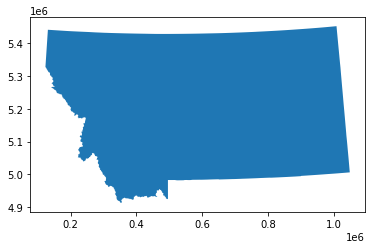

In [97]:
#Adding Montana counties outlines
MT = gpd.read_file('/content/State_of_Montana__Boundary.geojson')
MT = MT.set_crs(epsg = 4326) #coordinate System
MT = MT.to_crs(epsg=3742)
MT.head()
MT.plot()

In [107]:
#Creating GeoDataFrame that is grouped by station and month for mapping
SM = clean.groupby(['station_key', 'month'],as_index=False).mean()
SM = SM.drop(columns = ['year']) #drop year column
#turn the group by series into a dataframe that statistics can be calculated on (thank you Stack Overflow!)
BySM = pd.DataFrame(SM)
BySM
#convert in geodataframe for mapping
gdf = gpd.GeoDataFrame(BySM, geometry=gpd.points_from_xy(BySM.longitude, BySM.latitude))
gdf = gdf.set_crs(epsg=4326)
gdfr = gdf.round(2)

#project data
gdfr = gdfr.to_crs(epsg = 3742)
#creating July temperatures separation
JulyBySM = gdfr.loc[(BySM['month'] == 7)]

#creating January temperatures separation
JanBySM = gdfr.loc[(BySM['month'] == 1)]
JanBySM

,station_key,month,mean_min_temp,mean_max_temp,longitude,latitude,elevation,geometry
0,arskeogh,1,-9.03,1.02,-105.95,46.41,818.85,POINT (888111.269 5152006.138)
12,arskeose,1,-12.86,-0.67,-105.83,46.35,746.04,POINT (897769.054 5145937.857)
24,arskeosw,1,-6.86,2.57,-105.98,46.30,849.20,POINT (886582.738 5139638.752)
36,bentlake,1,-8.45,3.41,-111.47,47.69,1129.44,POINT (464731.580 5281952.161)
48,blm1arge,1,-7.43,0.89,-112.88,45.25,1898.93,POINT (352474.176 5012441.299)
...,...,...,...,...,...,...,...,...
902,wsrbigtm,1,-4.10,4.46,-109.83,45.74,1335.29,POINT (591019.995 5065825.236)
914,wsrboydw,1,-5.86,2.77,-109.26,45.47,1429.65,POINT (636013.436 5036635.382)
926,wsrbroad,1,-6.39,3.81,-108.76,46.13,1239.41,POINT (673040.986 5110929.933)
938,wsrmelvi,1,-6.49,4.02,-109.84,46.00,1430.15,POINT (589822.224 5094700.855)


In [99]:
print(MT.crs)
print(gdfr.crs)

epsg:3742
epsg:3742


No handles with labels found to put in legend.


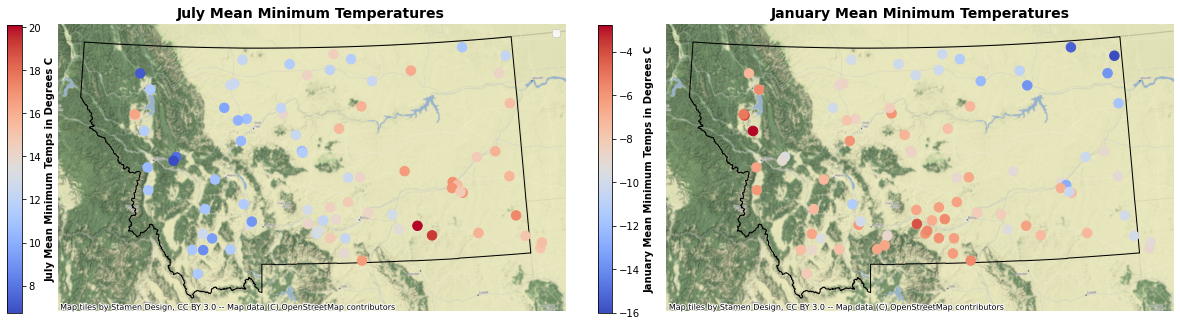

In [109]:
#Plotting January and July Mean Minimum temps
fig, ax = plt.subplots(1, 2, figsize=(20,10))
cmap = plt.get_cmap('coolwarm')

MT.plot(ax=ax[0], facecolor='none', edgecolor='black', linewidth=1)
#setvariables for later
xs = JulyBySM.geometry.x
ys = JulyBySM.geometry.y

#July Data
sc = ax[0].scatter(JulyBySM.geometry.x, JulyBySM.geometry.y, c=JulyBySM.mean_min_temp, cmap=cmap, s=90)
ax[0].set_title('July Mean Minimum Temperatures', weight = 'bold', size = 14)
ax[0].legend()
cbar_ax = fig.add_axes([0.09, 0.3, 0.01, 0.4])
cb = fig.colorbar(sc, cax=cbar_ax, orientation = 'vertical')
cb.set_label('July Mean Minimum Temps in Degrees C',weight='bold')

ax[0].axis('off')
ctx.add_basemap(
    ax[0], 
    crs=gdfr.crs)

#January Data
MT.plot(ax=ax[1], facecolor='none', edgecolor='black', linewidth=1)
xs1 = JanBySM.geometry.x
ys1 = JanBySM.geometry.y

sc2 = ax[1].scatter(JanBySM.geometry.x, JanBySM.geometry.y, c=JanBySM.mean_min_temp, s=90, cmap=cmap)
ax[1].set_title('January Mean Minimum Temperatures', weight = 'bold', size = 14)
cbar_ax2 = fig.add_axes([0.5, 0.3, 0.01, 0.4])
cb2 = fig.colorbar(sc2, cax=cbar_ax2, orientation = 'vertical')
cb2.set_label('January Mean Minimum Temps in Degrees C',weight='bold')

ax[1].axis('off')
ctx.add_basemap(
    ax[1], 
    crs=gdfr.crs)


No handles with labels found to put in legend.


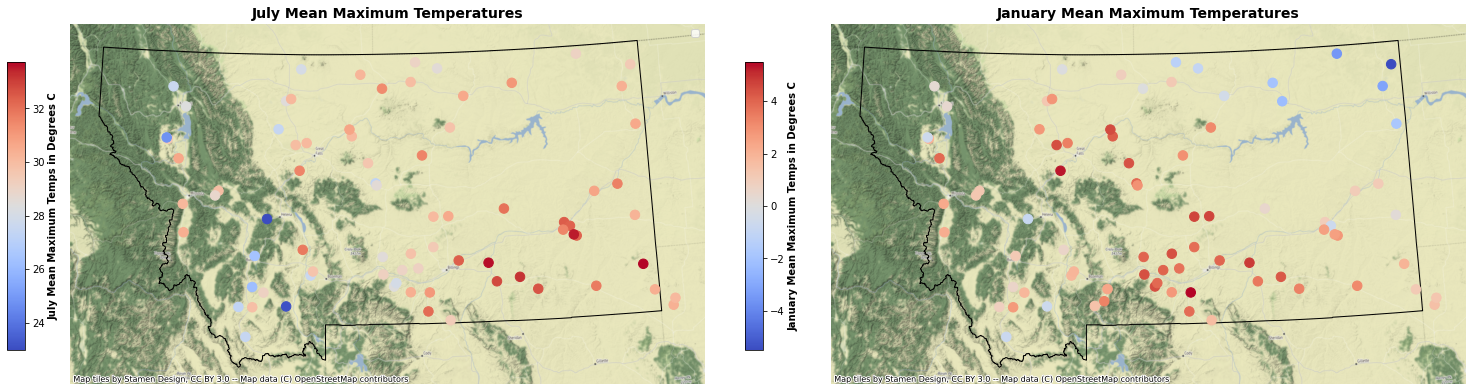

In [110]:
#Plotting January and July Mean Maximum temps
fig, ax = plt.subplots(1, 2, figsize=(25,10))
cmap = plt.get_cmap('coolwarm')

MT.plot(ax=ax[0], facecolor='none', edgecolor='black', linewidth=1)
#setvariables for later
xs = JulyBySM.geometry.x
ys = JulyBySM.geometry.y

#July Data
sc = ax[0].scatter(JulyBySM.geometry.x, JulyBySM.geometry.y, c=JulyBySM.mean_max_temp, cmap=cmap, s=90)
ax[0].set_title('July Mean Maximum Temperatures', weight = 'bold', size = 14)
ax[0].legend()
cbar_ax = fig.add_axes([0.09, 0.3, 0.01, 0.4])
cb = fig.colorbar(sc, cax=cbar_ax, orientation = 'vertical')
cb.set_label('July Mean Maximum Temps in Degrees C',weight='bold')

ax[0].axis('off')
ctx.add_basemap(ax[0], crs=gdfr.crs)
#January Data
MT.plot(ax=ax[1], facecolor='none', edgecolor='black', linewidth=1)
xs1 = JanBySM.geometry.x
ys1 = JanBySM.geometry.y

sc2 = ax[1].scatter(JanBySM.geometry.x, JanBySM.geometry.y, c=JanBySM.mean_max_temp, s=90, cmap=cmap)
ax[1].set_title('January Mean Maximum Temperatures', weight = 'bold', size = 14)
ax[1].axis('off')
cbar_ax2 = fig.add_axes([0.5, 0.3, 0.01, 0.4])
cb2 = fig.colorbar(sc2, cax=cbar_ax2, orientation = 'vertical')
cb2.set_label('January Mean Maximum Temps in Degrees C',weight='bold')

ax[1].axis('off')
ctx.add_basemap(ax[1], crs=gdfr.crs)

#Plotting Geographic Mean of weather stations on Temperature Data

In [121]:
# Calculate mean
# First create a dataframe
centroid = gdfr[['latitude', 'longitude']]
centroid["lat_rad"] = gdfr["latitude"] * math.pi/180 #Compute lat and lon in radians and save to new df
centroid["lon_rad"] = gdfr["longitude"] *math.pi/180

# Now transpose onto the XYZ spheroid
centroid['X'] = np.cos(centroid.lat_rad)*np.cos(centroid.lon_rad) 
centroid['Y'] = np.cos(centroid.lat_rad)*np.sin(centroid.lon_rad)
centroid['Z'] = np.sin(centroid.lat_rad)

centroid.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,latitude,longitude,lat_rad,lon_rad,X,Y,Z
0,46.41,-105.95,0.810007,-1.849176,-0.189472,-0.662949,0.724292
1,46.41,-105.95,0.810007,-1.849176,-0.189472,-0.662949,0.724292
2,46.41,-105.95,0.810007,-1.849176,-0.189472,-0.662949,0.724292
3,46.41,-105.95,0.810007,-1.849176,-0.189472,-0.662949,0.724292
4,46.41,-105.95,0.810007,-1.849176,-0.189472,-0.662949,0.724292


In [122]:
#reateing location mean for the geographic center
centroid = np.mean(centroid)
centroid.head()

latitude      46.723628
longitude   -109.360010
lat_rad        0.815481
lon_rad       -1.908692
X             -0.226815
dtype: float64

In [123]:
#Put lat and long into x-y
PI = 3.14

centroid['meanLon'] = (np.arctan2(centroid.Y, centroid.X))*180/PI

centroid['hyp'] = np.sqrt(centroid.X * centroid.X + centroid.Y * centroid.Y)
centroid['meanLat'] = (np.arctan2(centroid.Z, centroid.hyp))*180/PI
centroid.head() ## Note this is a numpy array -> clean up and change to pandas dataframe.

centroid = centroid[['meanLat','meanLon']] # only use the lat/lon
centroid = pd.DataFrame(centroid) # convert to a df
centroid = centroid.transpose() # get it lined up properly
centroid # make sure that it worked

xyCenter = gpd.GeoDataFrame(centroid, geometry=gpd.points_from_xy(centroid.meanLon, centroid.meanLat))
xyCenter

,meanLat,meanLon,geometry
0,46.787142,-109.409232,POINT (-109.40923 46.78714)


In [124]:
#Create new geodataframe for center point and project it--same steps as above

xyCenter = xyCenter.set_crs(epsg = 4326) #WGS 84
xyCenter = xyCenter.to_crs(epsg = 3742) #UTM 12N
#Add columns"
xyCenter["x"] = xyCenter.geometry.x
xyCenter["y"] = xyCenter.geometry.y
#Remove colunms
xyCenter = xyCenter.drop(columns=['meanLat', 'meanLon'])
xyCenter.head()

,geometry,x,y
0,POINT (621418.535 5182738.255),621418.535307,5.182738e+06


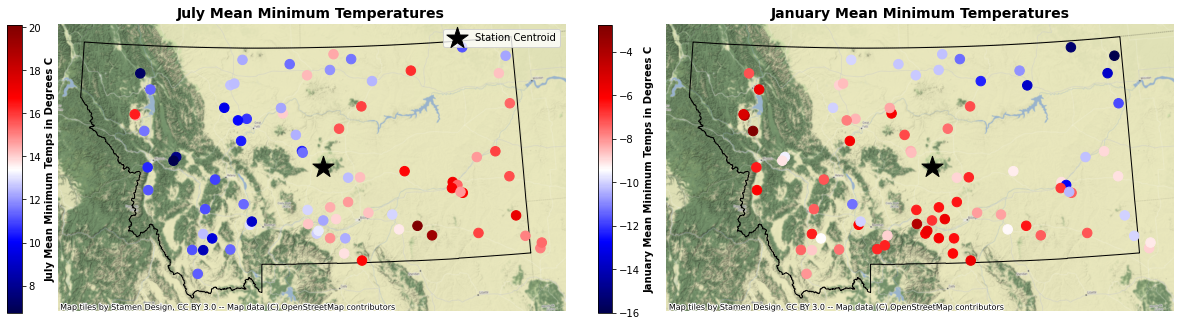

In [136]:
#Plotting January and July Mean Minimum temps
fig, ax = plt.subplots(1, 2, figsize=(20,10))
cmap = plt.get_cmap('seismic')

MT.plot(ax=ax[0], facecolor='none', edgecolor='black', linewidth=1)
#setvariables for later
xs = JulyBySM.geometry.x
ys = JulyBySM.geometry.y

xyCenter.plot(ax=ax[0], marker='*',color="black", markersize=500, label='Station Centroid',legend=True)


#July Data
sc = ax[0].scatter(JulyBySM.geometry.x, JulyBySM.geometry.y, c=JulyBySM.mean_min_temp, cmap=cmap, s=90)
ax[0].set_title('July Mean Minimum Temperatures', weight = 'bold', size = 14)
ax[0].legend()
cbar_ax = fig.add_axes([0.09, 0.3, 0.01, 0.4])
cb = fig.colorbar(sc, cax=cbar_ax, orientation = 'vertical')
cb.set_label('July Mean Minimum Temps in Degrees C',weight='bold')

ax[0].axis('off')
ctx.add_basemap(
    ax[0], 
    crs=gdfr.crs)

#January Data
MT.plot(ax=ax[1], facecolor='none', edgecolor='black', linewidth=1)
xs1 = JanBySM.geometry.x
ys1 = JanBySM.geometry.y

xyCenter.plot(ax=ax[1], marker='*',color="black", markersize=500, label='Station Centroid',legend=True)


sc2 = ax[1].scatter(JanBySM.geometry.x, JanBySM.geometry.y, c=JanBySM.mean_min_temp, s=90, cmap=cmap)
ax[1].set_title('January Mean Minimum Temperatures', weight = 'bold', size = 14)
cbar_ax2 = fig.add_axes([0.5, 0.3, 0.01, 0.4])
cb2 = fig.colorbar(sc2, cax=cbar_ax2, orientation = 'vertical')
cb2.set_label('January Mean Minimum Temps in Degrees C',weight='bold')

ax[1].axis('off')
ctx.add_basemap(
    ax[1], 
    crs=gdfr.crs)


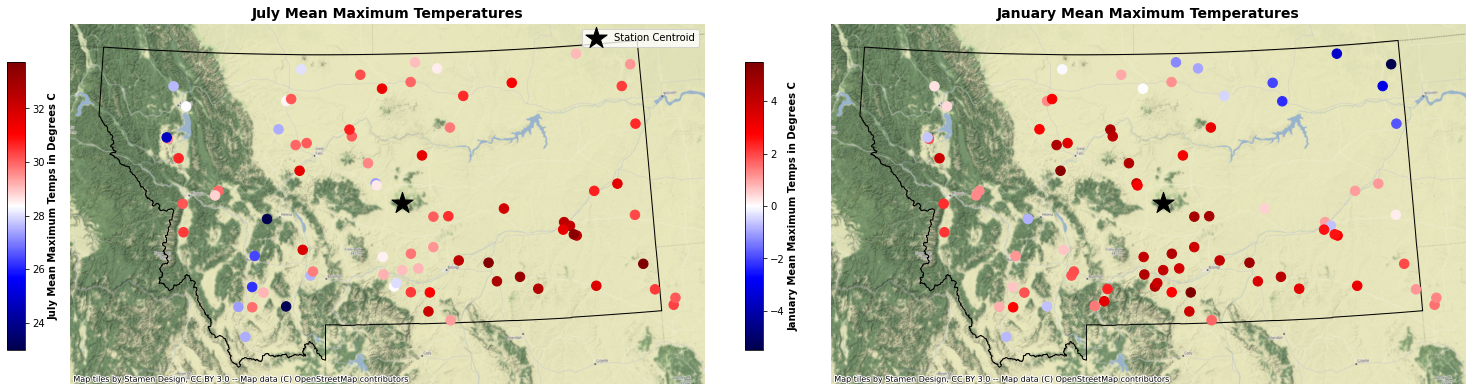

In [133]:
#Plotting January and July Mean Maximum temps WITH GEOGRAPHIC CENTER
fig, ax = plt.subplots(1, 2, figsize=(25,10))
cmap = plt.get_cmap('seismic')

MT.plot(ax=ax[0], facecolor='none', edgecolor='black', linewidth=1)
#setvariables for later
xs = JulyBySM.geometry.x
ys = JulyBySM.geometry.y

xyCenter.plot(ax=ax[0], marker='*',color="black", markersize=500, label='Station Centroid',legend=True)

#July Data
sc = ax[0].scatter(JulyBySM.geometry.x, JulyBySM.geometry.y, c=JulyBySM.mean_max_temp, cmap=cmap, s=90)
ax[0].set_title('July Mean Maximum Temperatures', weight = 'bold', size = 14)
ax[0].legend()
cbar_ax = fig.add_axes([0.09, 0.3, 0.01, 0.4])
cb = fig.colorbar(sc, cax=cbar_ax, orientation = 'vertical')
cb.set_label('July Mean Maximum Temps in Degrees C',weight='bold')

ax[0].axis('off')
ctx.add_basemap(ax[0], crs=gdfr.crs)
#January Data
MT.plot(ax=ax[1], facecolor='none', edgecolor='black', linewidth=1)
xs1 = JanBySM.geometry.x
ys1 = JanBySM.geometry.y

xyCenter.plot(ax=ax[1], marker='*',color="black", markersize=500, label='Station Centroid',legend=True)

sc2 = ax[1].scatter(JanBySM.geometry.x, JanBySM.geometry.y, c=JanBySM.mean_max_temp, s=90, cmap=cmap)
ax[1].set_title('January Mean Maximum Temperatures', weight = 'bold', size = 14)
ax[1].axis('off')
cbar_ax2 = fig.add_axes([0.5, 0.3, 0.01, 0.4])
cb2 = fig.colorbar(sc2, cax=cbar_ax2, orientation = 'vertical')
cb2.set_label('January Mean Maximum Temps in Degrees C',weight='bold')

ax[1].axis('off')
ctx.add_basemap(ax[1], crs=gdfr.crs)
